# GAN for MNIST Dataset

In [1]:
'''
DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=False, samples=noise_input.shape[0],
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0 

14: [D loss: 0.643733, acc: 0.699219]  [A loss: 0.784882, acc: 0.480469]
15: [D loss: 1.626310, acc: 0.498047]  [A loss: 9.904360, acc: 0.000000]
16: [D loss: 0.694642, acc: 0.685547]  [A loss: 0.878061, acc: 0.453125]
17: [D loss: 1.688285, acc: 0.472656]  [A loss: 9.221987, acc: 0.000000]
18: [D loss: 0.818627, acc: 0.656250]  [A loss: 0.611743, acc: 0.664062]
19: [D loss: 1.668702, acc: 0.480469]  [A loss: 8.012609, acc: 0.000000]


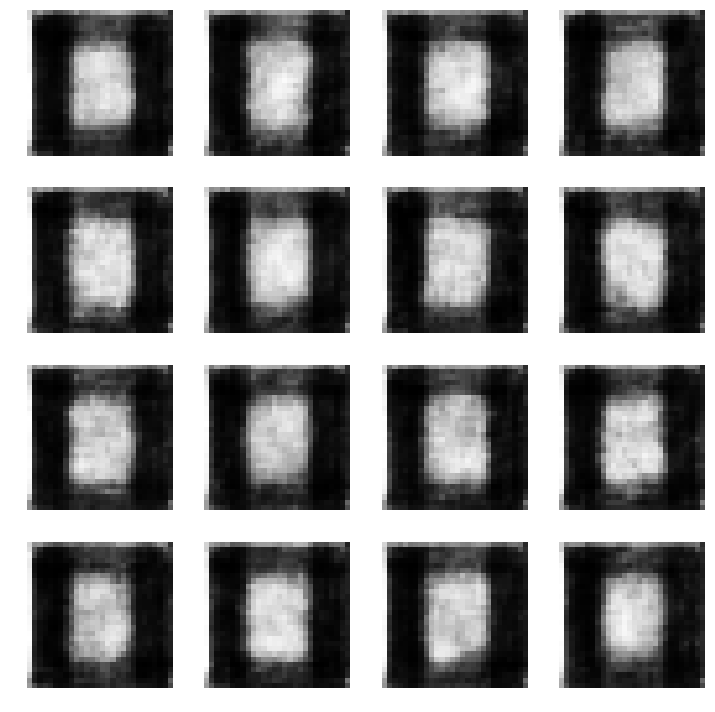

20: [D loss: 0.689707, acc: 0.712891]  [A loss: 0.953089, acc: 0.394531]
21: [D loss: 1.654067, acc: 0.466797]  [A loss: 8.733380, acc: 0.000000]
22: [D loss: 0.736623, acc: 0.666016]  [A loss: 0.728493, acc: 0.554688]
23: [D loss: 1.702950, acc: 0.482422]  [A loss: 8.013432, acc: 0.000000]
24: [D loss: 0.725663, acc: 0.689453]  [A loss: 0.765619, acc: 0.531250]
25: [D loss: 1.543565, acc: 0.466797]  [A loss: 7.391670, acc: 0.000000]
26: [D loss: 0.696367, acc: 0.693359]  [A loss: 0.915088, acc: 0.386719]
27: [D loss: 1.601742, acc: 0.484375]  [A loss: 7.644707, acc: 0.000000]
28: [D loss: 0.811267, acc: 0.609375]  [A loss: 0.549309, acc: 0.714844]
29: [D loss: 1.519066, acc: 0.482422]  [A loss: 6.273540, acc: 0.000000]
30: [D loss: 0.658853, acc: 0.716797]  [A loss: 1.067093, acc: 0.242188]
31: [D loss: 1.381969, acc: 0.480469]  [A loss: 6.793092, acc: 0.000000]
32: [D loss: 0.708559, acc: 0.683594]  [A loss: 0.555148, acc: 0.726562]
33: [D loss: 1.444291, acc: 0.492188]  [A loss: 6.6

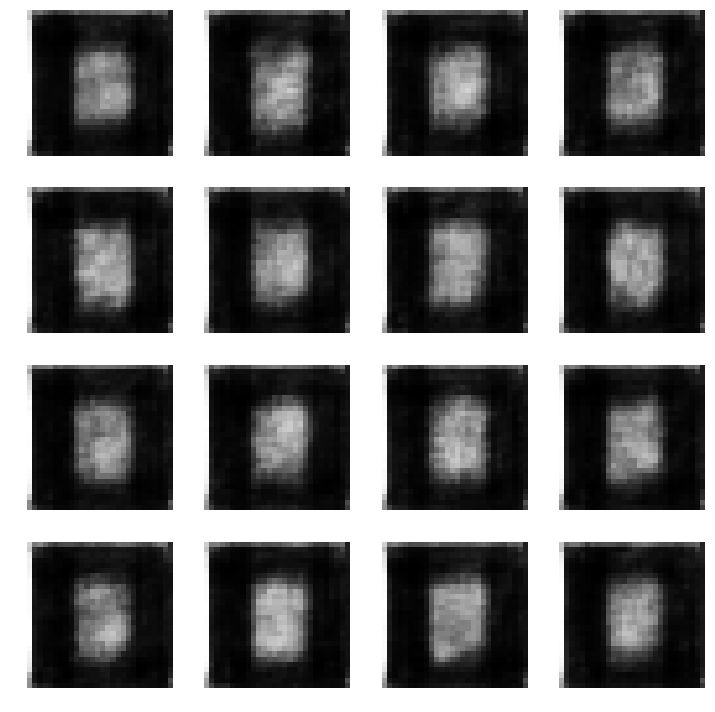

40: [D loss: 0.588871, acc: 0.722656]  [A loss: 0.483431, acc: 0.808594]
41: [D loss: 1.202605, acc: 0.503906]  [A loss: 5.570931, acc: 0.000000]
42: [D loss: 0.540531, acc: 0.744141]  [A loss: 0.456121, acc: 0.820312]
43: [D loss: 1.216213, acc: 0.501953]  [A loss: 5.798395, acc: 0.000000]
44: [D loss: 0.558637, acc: 0.736328]  [A loss: 0.356158, acc: 0.968750]
45: [D loss: 1.201655, acc: 0.500000]  [A loss: 5.684054, acc: 0.000000]
46: [D loss: 0.537760, acc: 0.767578]  [A loss: 0.359363, acc: 0.925781]
47: [D loss: 1.162566, acc: 0.500000]  [A loss: 4.974673, acc: 0.000000]
48: [D loss: 0.426442, acc: 0.867188]  [A loss: 0.782917, acc: 0.464844]
49: [D loss: 1.096714, acc: 0.505859]  [A loss: 6.839861, acc: 0.000000]
50: [D loss: 0.615170, acc: 0.683594]  [A loss: 0.177227, acc: 1.000000]
51: [D loss: 1.285926, acc: 0.500000]  [A loss: 4.008631, acc: 0.000000]
52: [D loss: 0.411645, acc: 0.849609]  [A loss: 1.368565, acc: 0.074219]
53: [D loss: 1.020466, acc: 0.507812]  [A loss: 7.4

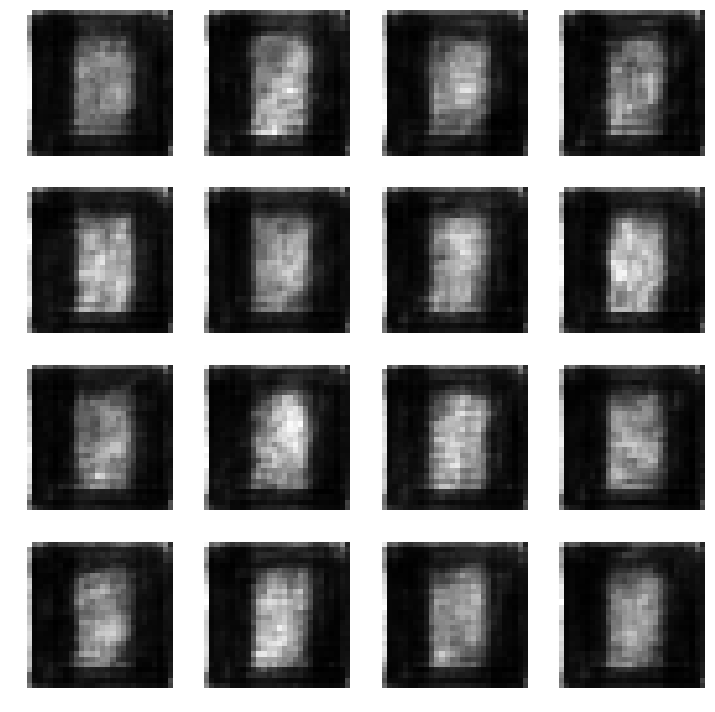

60: [D loss: 0.445248, acc: 0.761719]  [A loss: 2.101038, acc: 0.011719]
61: [D loss: 0.727082, acc: 0.562500]  [A loss: 5.874691, acc: 0.000000]
62: [D loss: 0.485818, acc: 0.814453]  [A loss: 0.184363, acc: 1.000000]
63: [D loss: 1.251187, acc: 0.500000]  [A loss: 4.937504, acc: 0.000000]


KeyboardInterrupt: 

In [3]:
mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=20)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=False)